Theory : https://towardsdatascience.com/understanding-random-forest-58381e0602d2

Examples : https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

https://medium.com/dataman-in-ai/the-shap-with-more-elegant-charts-bc3e73fa1c0c

https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d

# Probability of surges

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
import shap

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import geopandas as gpd
from shapely.geometry import Polygon

import matplotlib.pyplot as plt

from sklearn.utils import resample

### Set random seed to ensure reproducible runs

In [2]:
RSEED = 50

### Importing data and data cleaning

In [3]:
df_main = pd.read_csv('/home/colili/Documents/PhD/project_john/DataFrame_produced/df_main.csv', index_col=['rgiid', 'x', 'y'])
df_main

Unnamed: 0  Surge   Area  Slope  \
rgiid          x             y                                               
RGI60-07.00004 524657.521964 8.539931e+06         206      0  1.044   13.8   
               524681.113471 8.539955e+06         207      0  1.044   13.8   
               524704.704977 8.539980e+06         208      0  1.044   13.8   
               524728.296484 8.540004e+06         209      0  1.044   13.8   
               524751.887990 8.540028e+06         210      0  1.044   13.8   
...                                               ...    ...    ...    ...   
RGI60-07.01567 534269.488654 8.675206e+06      130984      3  5.350   11.7   
               534310.362510 8.675249e+06      130985      3  5.350   11.7   
               534309.250485 8.675291e+06      130986      3  5.350   11.7   
               534308.138459 8.675333e+06      130987      3  5.350   11.7   
               534307.026431 8.675375e+06      130988      3  5.350   11.7   

                                           TermType          Name        bed  \
rgiid          x             y                                                 
RGI60-07.00004 524657.521964 8.539931e+06         0           NaN  889.68555   
               524681.113471 8.539955e+06         0           NaN  882.06460   
               524704.704977 8.539980e+06         0           NaN  882.06460   
               524728.296484 8.540004e+06         0           NaN  882.06460   
               524751.887990 8.540028e+06         0           NaN  881.31860   
...                                             ...           ...        ...   
RGI60-07.01567 534269.488654 8.675206e+06         0  Moeysalbreen  237.64468   
               534310.362510 8.675249e+06         0  Moeysalbreen  233.07228   
               534309.250485 8.675291e+06         0  Moeysalbreen  233.07228   
               534308.138459 8.675333e+06         0  Moeysalbreen  233.18828   
               534307.026431 8.675375e+06         0  Moeysalbreen  233.18828   

                                           thickness  surface_elevation  \
rgiid          x             y                                            
RGI60-07.00004 524657.521964 8.539931e+06  25.314478          915.00000   
               524681.113471 8.539955e+06  30.935455          913.00000   
               524704.704977 8.539980e+06  30.935455          913.00000   
               524728.296484 8.540004e+06  30.935455          913.00000   
               524751.887990 8.540028e+06  34.681380          916.00000   
...                                              ...                ...   
RGI60-07.01567 534269.488654 8.675206e+06  50.380424          288.02512   
               534310.362510 8.675249e+06  46.717087          279.78937   
               534309.250485 8.675291e+06  46.717087          279.78937   
               534308.138459 8.675333e+06  47.159560          280.34784   
               534307.026431 8.675375e+06  47.159560          280.34784   

                                                  ELA      beta       cmb  \
rgiid          x             y                                              
RGI60-07.00004 524657.521964 8.539931e+06  432.103017  0.005069  1.392706   
               524681.113471 8.539955e+06  432.421537  0.005068  1.391001   
               524704.704977 8.539980e+06  432.740057  0.005068  1.389296   
               524728.296484 8.540004e+06  433.058576  0.005067  1.387591   
               524751.887990 8.540028e+06  433.377096  0.005067  1.385886   
...                                               ...       ...       ...   
RGI60-07.01567 534269.488654 8.675206e+06  627.625366  0.004612 -1.412920   
               534310.362510 8.675249e+06  627.625366  0.004614 -1.423469   
               534309.250485 8.675291e+06  627.625366  0.004618 -1.395654   
               534308.138459 8.675333e+06  627.625366  0.004620 -1.382369   
               534307.026431 8.675375e+06  627.625366  0.004621 -1.369084   

         

In [4]:
df_main['SMB_calc'] = df_main['beta']*(df_main['surface_elevation']-df_main['ELA'])
df_main

Unnamed: 0  Surge   Area  Slope  \
rgiid          x             y                                               
RGI60-07.00004 524657.521964 8.539931e+06         206      0  1.044   13.8   
               524681.113471 8.539955e+06         207      0  1.044   13.8   
               524704.704977 8.539980e+06         208      0  1.044   13.8   
               524728.296484 8.540004e+06         209      0  1.044   13.8   
               524751.887990 8.540028e+06         210      0  1.044   13.8   
...                                               ...    ...    ...    ...   
RGI60-07.01567 534269.488654 8.675206e+06      130984      3  5.350   11.7   
               534310.362510 8.675249e+06      130985      3  5.350   11.7   
               534309.250485 8.675291e+06      130986      3  5.350   11.7   
               534308.138459 8.675333e+06      130987      3  5.350   11.7   
               534307.026431 8.675375e+06      130988      3  5.350   11.7   

                                           TermType          Name        bed  \
rgiid          x             y                                                 
RGI60-07.00004 524657.521964 8.539931e+06         0           NaN  889.68555   
               524681.113471 8.539955e+06         0           NaN  882.06460   
               524704.704977 8.539980e+06         0           NaN  882.06460   
               524728.296484 8.540004e+06         0           NaN  882.06460   
               524751.887990 8.540028e+06         0           NaN  881.31860   
...                                             ...           ...        ...   
RGI60-07.01567 534269.488654 8.675206e+06         0  Moeysalbreen  237.64468   
               534310.362510 8.675249e+06         0  Moeysalbreen  233.07228   
               534309.250485 8.675291e+06         0  Moeysalbreen  233.07228   
               534308.138459 8.675333e+06         0  Moeysalbreen  233.18828   
               534307.026431 8.675375e+06         0  Moeysalbreen  233.18828   

                                           thickness  surface_elevation  \
rgiid          x             y                                            
RGI60-07.00004 524657.521964 8.539931e+06  25.314478          915.00000   
               524681.113471 8.539955e+06  30.935455          913.00000   
               524704.704977 8.539980e+06  30.935455          913.00000   
               524728.296484 8.540004e+06  30.935455          913.00000   
               524751.887990 8.540028e+06  34.681380          916.00000   
...                                              ...                ...   
RGI60-07.01567 534269.488654 8.675206e+06  50.380424          288.02512   
               534310.362510 8.675249e+06  46.717087          279.78937   
               534309.250485 8.675291e+06  46.717087          279.78937   
               534308.138459 8.675333e+06  47.159560          280.34784   
               534307.026431 8.675375e+06  47.159560          280.34784   

                                                  ELA      beta       cmb  \
rgiid          x             y                                              
RGI60-07.00004 524657.521964 8.539931e+06  432.103017  0.005069  1.392706   
               524681.113471 8.539955e+06  432.421537  0.005068  1.391001   
               524704.704977 8.539980e+06  432.740057  0.005068  1.389296   
               524728.296484 8.540004e+06  433.058576  0.005067  1.387591   
               524751.887990 8.540028e+06  433.377096  0.005067  1.385886   
...                                               ...       ...       ...   
RGI60-07.01567 534269.488654 8.675206e+06  627.625366  0.004612 -1.412920   
               534310.362510 8.675249e+06  627.625366  0.004614 -1.423469   
               534309.250485 8.675291e+06  627.625366  0.004618 -1.395654   
               534308.138459 8.675333e+06  627.625366  0.004620 -1.382369   
               534307.026431 8.675375e+06  627.625366  0.004621 -1.369084   

         

In [4]:
df_main['WH'] = df_main['width_centerline'] / df_main['thickness']
df_main['WHsin'] = df_main['thickness']*df_main['width_centerline']*np.sin(df_main['Slope'])
df_main['dummy'] = np.random.rand(df_main.shape[0])

In [5]:
df = df_main.drop(df_main[df_main['Surge']==9].index)
df = df.drop(df_main[df_main['Surge']==1].index)
# df = df_main.drop(df_main[df_main['Surge']==2].index)
df = df.drop(columns = ['Unnamed: 0', 'ELA', 'beta', 'Name', 'Area', 'cmb'])
df.dropna(how='any', inplace=True)

In [6]:
df.groupby('Surge').count()

,Slope,TermType,bed,thickness,surface_elevation,width_centerline,Runoff,WH,WHsin,dummy
Surge,,,,,,,,,,
0,68707,68707,68707,68707,68707,68707,68707,68707,68707,68707
2,4249,4249,4249,4249,4249,4249,4249,4249,4249,4249
3,10905,10905,10905,10905,10905,10905,10905,10905,10905,10905


In [7]:
df['Surge'] = df['Surge'].replace({3: 1, 2:1})
df = df.loc[df['Surge'].isin([0, 1])].copy()
df = df.rename(columns = {'Surge': 'label'})
df['label'].value_counts()

0    68707
1    15154
Name: label, dtype: int64

In [8]:
df[df['label']==1].shape[0]

15154

In [9]:
df.shape

(83861, 11)

### Resampled

In [10]:
# Separate majority and minority classes
df_majority = df[df['label']==0]
df_minority = df[df['label']==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=df[df['label']==1].shape[0],     # to match minority class
                                 random_state=RSEED) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled['label'].value_counts()
df = df_downsampled

In [11]:
df_downsampled.shape

(30308, 11)

In [12]:
# Extract the labels
labels = np.array(df.pop('label'))

# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(df, labels, 
                                                          stratify = labels,
                                                          test_size = 0.3, 
                                                          random_state = RSEED)

In [13]:
train_labels.sum()/train_labels.shape[0]

0.5000235682300259

In [14]:
test_labels.sum()/test_labels.shape[0]

0.4999450126470912

In [15]:
# Features for feature importances
features = list(train.columns)
features

['Slope',
 'TermType',
 'bed',
 'thickness',
 'surface_elevation',
 'width_centerline',
 'Runoff',
 'WH',
 'WHsin',
 'dummy']

In [16]:
train.head()

Slope  TermType         bed  \
rgiid          x             y                                           
RGI60-07.00413 561423.459077 8.680275e+06   10.5         0  488.766540   
RGI60-07.01506 557199.611962 8.748855e+06    5.0         0  442.280940   
               555507.283362 8.750357e+06    5.0         0   49.635742   
RGI60-07.00031 721775.315692 8.890512e+06    9.0         1   10.183197   
RGI60-07.00913 661225.858487 8.681908e+06   10.3         0  258.591280   

                                            thickness  surface_elevation  \
rgiid          x             y                                             
RGI60-07.00413 561423.459077 8.680275e+06    69.23345           558.0000   
RGI60-07.01506 557199.611962 8.748855e+06   635.83307          1078.1140   
               555507.283362 8.750357e+06  1102.54250          1152.1782   
RGI60-07.00031 721775.315692 8.890512e+06   425.61740           435.8006   
RGI60-07.00913 661225.858487 8.681908e+06    84.40872           343.0000   

                                           width_centerline    Runoff  \
rgiid          x             y                                          
RGI60-07.00413 561423.459077 8.680275e+06       1476.827468  1.405988   
RGI60-07.01506 557199.611962 8.748855e+06       3967.363603  0.287400   
               555507.283362 8.750357e+06       1355.134690  0.257593   
RGI60-07.00031 721775.315692 8.890512e+06       8033.016942  0.623644   
RGI60-07.00913 661225.858487 8.681908e+06        777.342606  1.553226   

                                                  WH         WHsin     dummy  
rgiid          x             y                                                
RGI60-07.00413 561423.459077 8.680275e+06  21.331126 -8.994525e+04  0.790605  
RGI60-07.01506 557199.611962 8.748855e+06   6.239631 -2.418964e+06  0.540046  
               555507.283362 8.750357e+06   1.229100 -1.432723e+06  0.336032  
RGI60-07.00031 721775.315692 8.890512e+06  18.873798  1.409030e+06  0.046404  
RGI60-07.00913 661225.858487 8.681908e+06   9.209269 -5.037132e+04  0.618645

In [17]:
train_labels.shape

(21215,)

In [18]:
test.head()

,,,Slope,TermType,bed,thickness,surface_elevation,width_centerline,Runoff,WH,WHsin,dummy
rgiid,x,y,,,,,,,,,,
RGI60-07.01197,490311.400819,8.826407e+06,13.8,0,732.323900,34.676067,767.0000,791.377093,1.182118,22.821997,25896.750377,0.322109
RGI60-07.00913,660106.578750,8.681012e+06,10.3,0,293.097500,53.902504,347.0000,591.589175,1.301199,10.975171,-24480.070949,0.794639
RGI60-07.01464,465300.262593,8.763546e+06,6.1,0,117.051056,479.273220,596.3243,6798.275364,1.111937,14.184551,-593527.577506,0.412146
RGI60-07.01433,497817.166902,8.799100e+06,14.1,0,528.308600,72.162570,600.4712,675.273983,1.124381,9.357676,48695.852905,0.774449
RGI60-07.01215,500910.806757,8.796030e+06,12.7,0,688.971000,69.907430,758.8784,831.097760,0.786694,11.888547,7740.769417,0.314541


# Gradient boosting

In [19]:
train_labels = pd.DataFrame(train_labels).set_index(train.index)
train_labels_mean = train_labels.groupby('rgiid').mean()

In [20]:
test.shape

(9093, 10)

In [21]:
test_labels = pd.DataFrame(test_labels).set_index(test.index)
test_labels_mean = test_labels.groupby('rgiid').mean()

In [22]:
test_mean = test.groupby('rgiid').mean()
test_mean

,Slope,TermType,bed,thickness,surface_elevation,width_centerline,Runoff,WH,WHsin,dummy
rgiid,,,,,,,,,,
RGI60-07.00004,13.8,0,822.022120,31.644548,853.666667,470.483443,1.142335,15.176714,1.394491e+04,0.299575
RGI60-07.00006,12.6,1,240.186294,47.359162,287.545455,1128.065475,2.229379,23.743980,1.837773e+03,0.573353
RGI60-07.00010,16.0,0,315.920735,18.912603,334.833333,643.174096,2.294351,34.366161,-3.596495e+03,0.495061
RGI60-07.00024,19.4,0,363.452404,12.347595,375.800000,139.452795,2.001148,11.724387,9.238443e+02,0.539210
RGI60-07.00025,4.4,1,59.679119,273.002514,332.681633,21889.883783,1.375673,87.904808,-5.487702e+06,0.502893
...,...,...,...,...,...,...,...,...,...,...
RGI60-07.01562,10.7,0,270.273083,55.094404,325.367493,823.828399,1.367780,13.923289,-5.350185e+04,0.406428
RGI60-07.01563,11.9,0,214.633193,70.746904,285.380096,809.348443,1.522399,11.569220,-3.540542e+04,0.594724
RGI60-07.01564,6.0,0,410.422372,137.174321,547.596699,4434.812876,1.428161,44.333321,-1.545466e+05,0.456086


In [23]:
train_mean = train.groupby('rgiid').mean()
train_mean

,Slope,TermType,bed,thickness,surface_elevation,width_centerline,Runoff,WH,WHsin,dummy
rgiid,,,,,,,,,,
RGI60-07.00004,13.8,0,833.932733,32.733956,866.666667,437.481718,1.126239,13.778643,13346.806178,0.607539
RGI60-07.00006,12.6,1,237.238829,58.618313,295.857143,1173.156895,2.232954,21.543671,2331.153115,0.528018
RGI60-07.00008,14.8,0,163.971843,17.885300,181.857143,595.733227,2.739728,35.570298,8219.954972,0.597207
RGI60-07.00010,16.0,0,276.874211,18.375789,295.250000,547.679242,2.469958,29.596100,-2976.484887,0.521498
RGI60-07.00024,19.4,0,407.875787,14.207547,422.083333,276.648153,1.888698,19.649543,2158.094968,0.599022
...,...,...,...,...,...,...,...,...,...,...
RGI60-07.01562,10.7,0,227.527962,62.655583,290.183546,1590.181736,1.388642,24.083824,-101463.232463,0.301836
RGI60-07.01563,11.9,0,272.472891,68.345463,340.818355,893.383943,1.518375,15.261914,-34386.271322,0.404531
RGI60-07.01564,6.0,0,586.568254,126.308767,712.877027,3910.774535,1.139850,36.435071,-138173.650227,0.462566


# Gradient boosting

In [24]:
import xgboost
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

In [25]:
dmatrix_train = xgboost.DMatrix(train, label=train_labels)
dmatrix_test = xgboost.DMatrix(test, label=test_labels)

In [26]:
params = {'objective':'reg:logistic', 'max_depth':1, 'scale_pos_weight':0.5}
xgb = xgboost.train(params, dmatrix_train, num_boost_round=20000)

In [27]:
predictions_xgboost = xgb.predict(dmatrix_test)

In [28]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(test)

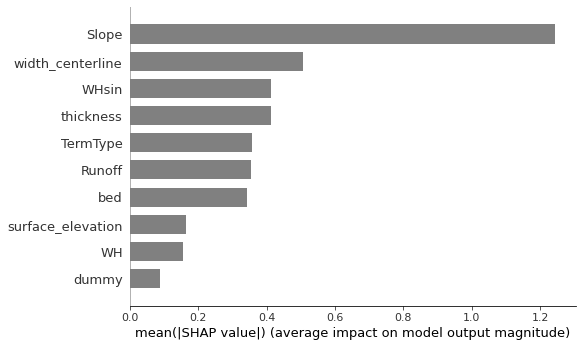

In [29]:
shap.summary_plot(shap_values, test, plot_type='bar', color='grey')

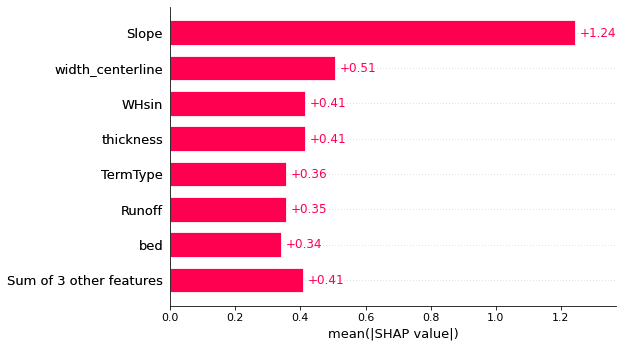

In [32]:
shap_values = explainer(test)
shap.plots.bar(shap_values, max_display=8)

We can visualize the importance of the features and their impact on the prediction by plotting summary charts. A variable importance plot lists the most significant variables in descending order. The top variables contribute more to the model than the bottom ones.

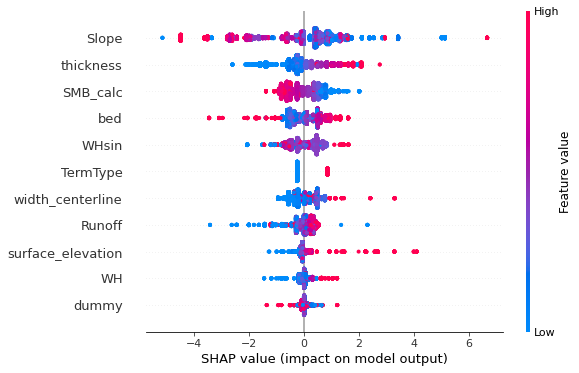

In [31]:
shap.summary_plot(shap_values, test)

This plot demonstrates the following information:

Feature importance: Variables are ranked in descending order.

Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.

Feature value: red indicating high and blue indicating low

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


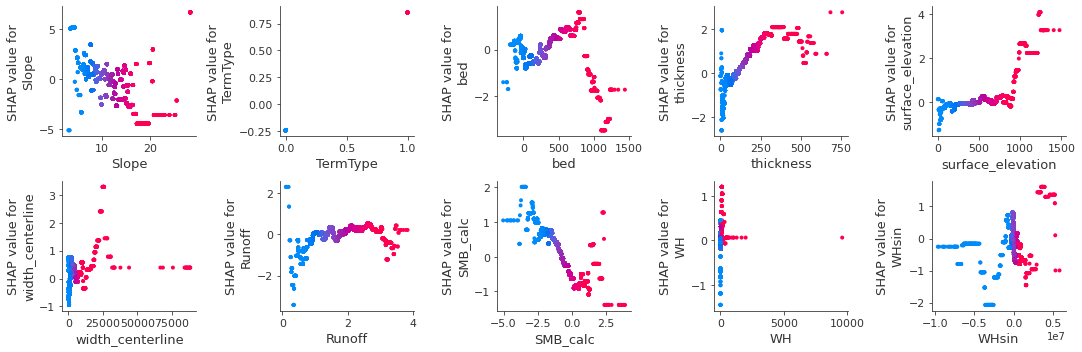

In [32]:
fig, axes = plt.subplots(figsize=(15,5), nrows=2, ncols=5)
axes = axes.ravel()
columns = test.columns[0:10]

for i, col in enumerate(columns):
    shap.dependence_plot(col, shap_values, test, ax=axes[i], show=False)
    plt.tight_layout()

In [33]:
test

,,,Slope,TermType,bed,thickness,surface_elevation,width_centerline,Runoff,SMB_calc,WH,WHsin,dummy
rgiid,x,y,,,,,,,,,,,
RGI60-07.00465,478371.303131,8.716493e+06,8.1,1,46.214294,221.837620,268.05190,5613.527053,2.654832,-1.401845,25.304667,1.207796e+06,0.692592
RGI60-07.01090,489770.321036,8.649560e+06,10.6,0,147.998780,71.059320,219.05810,645.227888,1.370421,-1.918945,9.080130,-4.230875e+04,0.689329
RGI60-07.00406,557921.341535,8.663047e+06,12.2,0,184.157470,48.189050,232.34653,619.202874,2.521803,-1.821770,12.849452,-1.068913e+04,0.774188
RGI60-07.00862,541092.973415,8.860543e+06,9.7,0,165.962950,90.943580,256.90652,276.764792,1.145731,-0.664016,3.043258,-6.840210e+03,0.067541
RGI60-07.00169,530699.535153,8.626463e+06,14.4,0,551.148100,41.851960,593.00000,1038.449988,1.399670,0.206295,24.812458,4.196861e+04,0.303156
...,...,...,...,...,...,...,...,...,...,...,...,...,...
RGI60-07.01164,490373.714054,8.827258e+06,11.0,0,779.663400,29.336622,809.00000,610.638536,1.196574,-0.154676,20.814889,-1.791390e+04,0.193356
RGI60-07.00244,517785.529431,8.572797e+06,8.7,1,159.438140,326.561860,486.00000,3647.614162,1.632135,-0.321394,11.169749,7.897102e+05,0.342546
RGI60-07.01324,438854.874150,8.849988e+06,28.3,0,390.872800,21.127195,412.00000,384.196907,2.246294,-0.467437,18.184946,-2.083091e+02,0.014874


In [34]:
shap.initjs()

In [35]:
shap.force_plot(explainer.expected_value, shap_values[0], test.iloc[0])

output value — this is the value predicted for our observation by our model. 

base value — this is the average prediction value returned for our observations

colors: variables that push the prediction higher (to the right) are shown in red, and those pushing the prediction lower are in blue

# All database

In [36]:
test_full_labels = df_main['Surge']
# test_full = df_main.dropna(inplace=True)
test_full = df_main.drop(columns=['Unnamed: 0', 'Surge', 'Area', 'Name', 'ELA', 'beta', 'cmb'])
test_full

Slope  TermType        bed  \
rgiid          x             y                                          
RGI60-07.00004 524657.521964 8.539931e+06   13.8         0  889.68555   
               524681.113471 8.539955e+06   13.8         0  882.06460   
               524704.704977 8.539980e+06   13.8         0  882.06460   
               524728.296484 8.540004e+06   13.8         0  882.06460   
               524751.887990 8.540028e+06   13.8         0  881.31860   
...                                          ...       ...        ...   
RGI60-07.01567 534269.488654 8.675206e+06   11.7         0  237.64468   
               534310.362510 8.675249e+06   11.7         0  233.07228   
               534309.250485 8.675291e+06   11.7         0  233.07228   
               534308.138459 8.675333e+06   11.7         0  233.18828   
               534307.026431 8.675375e+06   11.7         0  233.18828   

                                           thickness  surface_elevation  \
rgiid          x             y                                            
RGI60-07.00004 524657.521964 8.539931e+06  25.314478          915.00000   
               524681.113471 8.539955e+06  30.935455          913.00000   
               524704.704977 8.539980e+06  30.935455          913.00000   
               524728.296484 8.540004e+06  30.935455          913.00000   
               524751.887990 8.540028e+06  34.681380          916.00000   
...                                              ...                ...   
RGI60-07.01567 534269.488654 8.675206e+06  50.380424          288.02512   
               534310.362510 8.675249e+06  46.717087          279.78937   
               534309.250485 8.675291e+06  46.717087          279.78937   
               534308.138459 8.675333e+06  47.159560          280.34784   
               534307.026431 8.675375e+06  47.159560          280.34784   

                                           width_centerline    Runoff  \
rgiid          x             y                                          
RGI60-07.00004 524657.521964 8.539931e+06        279.780932  1.100061   
               524681.113471 8.539955e+06        295.980219  1.094416   
               524704.704977 8.539980e+06        330.851846  1.088771   
               524728.296484 8.540004e+06        342.886985  1.083127   
               524751.887990 8.540028e+06        336.403639  1.077530   
...                                                     ...       ...   
RGI60-07.01567 534269.488654 8.675206e+06        278.553621  2.123592   
               534310.362510 8.675249e+06        256.755923  2.127417   
               534309.250485 8.675291e+06        238.477978  2.076787   
               534308.138459 8.675333e+06        226.342325  2.005969   
               534307.026431 8.675375e+06        215.631320  1.935151   

                                           SMB_calc         WH         WHsin  \
rgiid          x             y                                                 
RGI60-07.00004 524657.521964 8.539931e+06  2.447634  11.052210   6683.732353   
               524681.113471 8.539955e+06  2.435692   9.567670   8640.744376   
               524704.704977 8.539980e+06  2.433887  10.694908   9658.774620   
               524728.296484 8.540004e+06  2.432082  11.083948  10010.124318   
               524751.887990 8.540028e+06  2.445479   9.699834  11010.043050   
...                                             ...        ...           ...   
RGI60-07.01567 534269.488654 8.675206e+06 -1.566323   5.529005 -10693.410549   
               534310.362510 8.675249e+06 -1.604864   5.495975  -9139.908345   
               534309.250485 8.675291e+06 -1.606379   5.104727  -8489.256385   
               534308.138459 8.675333e+06 -1.604294   4.799500  -8133.568561   
               534307.026431 8.675375e+06 -1.604788   4.572378  -7748.670623   

                                              dummy  
rgiid          x             y                       
RGI60-07.00004 524

In [37]:
dmatrix_test_full = xgboost.DMatrix(test_full, label=test_full_labels)

In [38]:
predictions_xgboost = xgb.predict(dmatrix_test_full)

In [39]:
b

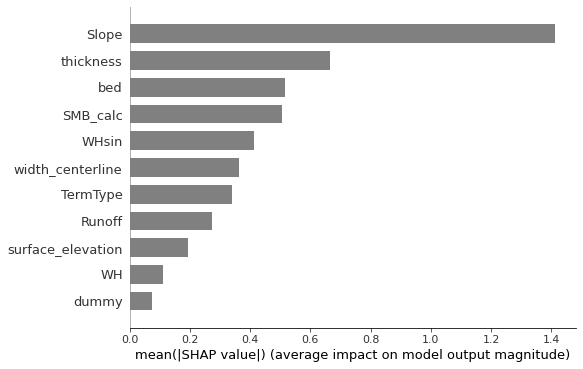

In [40]:
shap.summary_plot(shap_values, test_full, plot_type='bar', color='grey')

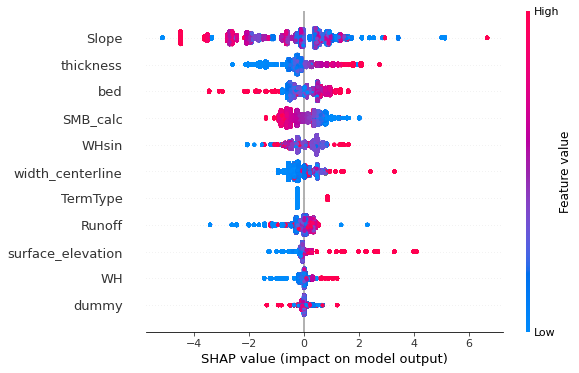

In [41]:
shap.summary_plot(shap_values, test_full)

invalid value encountered in true_divide
invalid value encountered in true_divide
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


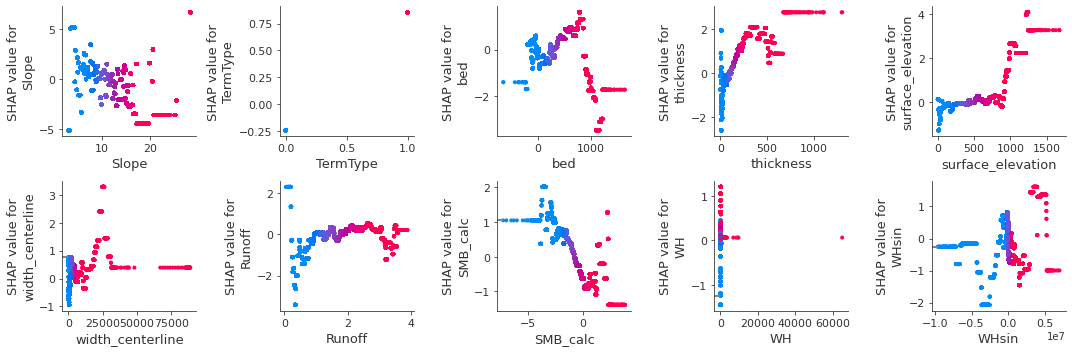

In [42]:
fig, axes = plt.subplots(figsize=(15,5), nrows=2, ncols=5)
axes = axes.ravel()
columns = test_full.columns[0:10]

for i, col in enumerate(columns):
    shap.dependence_plot(col, shap_values, test_full, ax=axes[i], show=False)
    plt.tight_layout()

In [43]:
shap.force_plot(explainer.expected_value, shap_values[0], test_full.iloc[0])

In [44]:
test_full

Slope  TermType        bed  \
rgiid          x             y                                          
RGI60-07.00004 524657.521964 8.539931e+06   13.8         0  889.68555   
               524681.113471 8.539955e+06   13.8         0  882.06460   
               524704.704977 8.539980e+06   13.8         0  882.06460   
               524728.296484 8.540004e+06   13.8         0  882.06460   
               524751.887990 8.540028e+06   13.8         0  881.31860   
...                                          ...       ...        ...   
RGI60-07.01567 534269.488654 8.675206e+06   11.7         0  237.64468   
               534310.362510 8.675249e+06   11.7         0  233.07228   
               534309.250485 8.675291e+06   11.7         0  233.07228   
               534308.138459 8.675333e+06   11.7         0  233.18828   
               534307.026431 8.675375e+06   11.7         0  233.18828   

                                           thickness  surface_elevation  \
rgiid          x             y                                            
RGI60-07.00004 524657.521964 8.539931e+06  25.314478          915.00000   
               524681.113471 8.539955e+06  30.935455          913.00000   
               524704.704977 8.539980e+06  30.935455          913.00000   
               524728.296484 8.540004e+06  30.935455          913.00000   
               524751.887990 8.540028e+06  34.681380          916.00000   
...                                              ...                ...   
RGI60-07.01567 534269.488654 8.675206e+06  50.380424          288.02512   
               534310.362510 8.675249e+06  46.717087          279.78937   
               534309.250485 8.675291e+06  46.717087          279.78937   
               534308.138459 8.675333e+06  47.159560          280.34784   
               534307.026431 8.675375e+06  47.159560          280.34784   

                                           width_centerline    Runoff  \
rgiid          x             y                                          
RGI60-07.00004 524657.521964 8.539931e+06        279.780932  1.100061   
               524681.113471 8.539955e+06        295.980219  1.094416   
               524704.704977 8.539980e+06        330.851846  1.088771   
               524728.296484 8.540004e+06        342.886985  1.083127   
               524751.887990 8.540028e+06        336.403639  1.077530   
...                                                     ...       ...   
RGI60-07.01567 534269.488654 8.675206e+06        278.553621  2.123592   
               534310.362510 8.675249e+06        256.755923  2.127417   
               534309.250485 8.675291e+06        238.477978  2.076787   
               534308.138459 8.675333e+06        226.342325  2.005969   
               534307.026431 8.675375e+06        215.631320  1.935151   

                                           SMB_calc         WH         WHsin  \
rgiid          x             y                                                 
RGI60-07.00004 524657.521964 8.539931e+06  2.447634  11.052210   6683.732353   
               524681.113471 8.539955e+06  2.435692   9.567670   8640.744376   
               524704.704977 8.539980e+06  2.433887  10.694908   9658.774620   
               524728.296484 8.540004e+06  2.432082  11.083948  10010.124318   
               524751.887990 8.540028e+06  2.445479   9.699834  11010.043050   
...                                             ...        ...           ...   
RGI60-07.01567 534269.488654 8.675206e+06 -1.566323   5.529005 -10693.410549   
               534310.362510 8.675249e+06 -1.604864   5.495975  -9139.908345   
               534309.250485 8.675291e+06 -1.606379   5.104727  -8489.256385   
               534308.138459 8.675333e+06 -1.604294   4.799500  -8133.568561   
               534307.026431 8.675375e+06 -1.604788   4.572378  -7748.670623   

                                              dummy  
rgiid          x             y                       
RGI60-07.00004 524

In [45]:
test_full = test_full.set_index((np.arange(0, test_full.shape[0], 1)), append=True)
test_full.index.names = ['rgiid', 'x', 'y', 'index']
test_full

Slope  TermType        bed  \
rgiid          x             y            index                               
RGI60-07.00004 524657.521964 8.539931e+06 0       13.8         0  889.68555   
               524681.113471 8.539955e+06 1       13.8         0  882.06460   
               524704.704977 8.539980e+06 2       13.8         0  882.06460   
               524728.296484 8.540004e+06 3       13.8         0  882.06460   
               524751.887990 8.540028e+06 4       13.8         0  881.31860   
...                                                ...       ...        ...   
RGI60-07.01567 534269.488654 8.675206e+06 94229   11.7         0  237.64468   
               534310.362510 8.675249e+06 94230   11.7         0  233.07228   
               534309.250485 8.675291e+06 94231   11.7         0  233.07228   
               534308.138459 8.675333e+06 94232   11.7         0  233.18828   
               534307.026431 8.675375e+06 94233   11.7         0  233.18828   

                                                 thickness  surface_elevation  \
rgiid          x             y            index                                 
RGI60-07.00004 524657.521964 8.539931e+06 0      25.314478          915.00000   
               524681.113471 8.539955e+06 1      30.935455          913.00000   
               524704.704977 8.539980e+06 2      30.935455          913.00000   
               524728.296484 8.540004e+06 3      30.935455          913.00000   
               524751.887990 8.540028e+06 4      34.681380          916.00000   
...                                                    ...                ...   
RGI60-07.01567 534269.488654 8.675206e+06 94229  50.380424          288.02512   
               534310.362510 8.675249e+06 94230  46.717087          279.78937   
               534309.250485 8.675291e+06 94231  46.717087          279.78937   
               534308.138459 8.675333e+06 94232  47.159560          280.34784   
               534307.026431 8.675375e+06 94233  47.159560          280.34784   

                                                 width_centerline    Runoff  \
rgiid          x             y            index                               
RGI60-07.00004 524657.521964 8.539931e+06 0            279.780932  1.100061   
               524681.113471 8.539955e+06 1            295.980219  1.094416   
               524704.704977 8.539980e+06 2            330.851846  1.088771   
               524728.296484 8.540004e+06 3            342.886985  1.083127   
               524751.887990 8.540028e+06 4            336.403639  1.077530   
...                                                           ...       ...   
RGI60-07.01567 534269.488654 8.675206e+06 94229        278.553621  2.123592   
               534310.362510 8.675249e+06 94230        256.755923  2.127417   
               534309.250485 8.675291e+06 94231        238.477978  2.076787   
               534308.138459 8.675333e+06 94232        226.342325  2.005969   
               534307.026431 8.675375e+06 94233        215.631320  1.935151   

                                                 SMB_calc         WH  \
rgiid          x             y            index                        
RGI60-07.00004 524657.521964 8.539931e+06 0      2.447634  11.052210   
               524681.113471 8.539955e+06 1      2.435692   9.567670   
               524704.704977 8.539980e+06 2      2.433887  10.694908   
               524728.296484 8.540004e+06 3      2.432082  11.083948   
               524751.887990 8.540028e+06 4      2.445479   9.699834   
...                                                   ...        ...   
RGI60-07.01567 534269.488654 8.675206e+06 94229 -1.566323   5.529005   
               534310.362510 8.675249e+06 94230 -1.604864   5.495975   
               534309.250485 8.675291e+06 94231 -1.606379   5.104727   
               534308.138459 8.675333e+06 94232 -1.604294   4.799500   
               534307.026431 8.675375e+06 94233 -1.604788   4.572378   

  

### Austfonna basin 3

### Map of proba

In [46]:
xgb = xgboost.XGBClassifier(**params)
xgb.fit(train, train_labels)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='reg:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=0.5, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [47]:
# predictions_xgboost = xgb.predict(dmatrix_test)
predictions_xgboost = xgb.predict(test_full)
probabilities_xgboost = xgb.predict_proba(test_full)
# probabilities_xgboost = xgb.predict_proba(test)
# probabilities_xgboost = xgb.predict_proba(dmatrix_test)
prob_0 = []
prob_1 = []
for n in np.arange(0, probabilities_xgboost.shape[0], 1):
    prob_0.append(probabilities_xgboost[:][:][n][0])
    prob_1.append(probabilities_xgboost[:][:][n][1])
    
df_probability_surge_full = pd.DataFrame({'Probability_0':prob_0, 'Probability_1':prob_1, 'Predictions':predictions_xgboost}, index=test_full.index)
df_probability_surge_full.reset_index(['x', 'y'], inplace=True)
df_probability_surge_full

x             y  Probability_0  \
rgiid          index                                               
RGI60-07.00004 0      524657.521964  8.539931e+06       0.871139   
               1      524681.113471  8.539955e+06       0.871139   
               2      524704.704977  8.539980e+06       0.871139   
               3      524728.296484  8.540004e+06       0.871139   
               4      524751.887990  8.540028e+06       0.871139   
...                             ...           ...            ...   
RGI60-07.01567 94229  534269.488654  8.675206e+06       0.743000   
               94230  534310.362510  8.675249e+06       0.743000   
               94231  534309.250485  8.675291e+06       0.754379   
               94232  534308.138459  8.675333e+06       0.754379   
               94233  534307.026431  8.675375e+06       0.791466   

                      Probability_1  Predictions  
rgiid          index                              
RGI60-07.00004 0           0.128861            0  
               1           0.128861            0  
               2           0.128861            0  
               3           0.128861            0  
               4           0.128861            0  
...                             ...          ...  
RGI60-07.01567 94229       0.257000            0  
               94230       0.257000            0  
               94231       0.245621            0  
               94232       0.245621            0  
               94233       0.208534            0  

[94234 rows x 5 columns]

In [48]:
import pandas as pd
import geopandas as gpd

import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import geopandas as gpd
from shapely.geometry import Polygon

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size

import rioxarray as rxr

### Austfonna basin 3

In [49]:
aust_basin3_map = df_probability_surge_full.loc[['RGI60-07.00027']]
# aust_basin3_map
brasvel_map = df_probability_surge_full.loc[['RGI60-07.00025']]
# brasvel_map
morsne_map = df_probability_surge_full.loc[['RGI60-07.00296']]
tuna_map = df_probability_surge_full.loc[['RGI60-07.01458']]
kongs_map = df_probability_surge_full.loc[['RGI60-07.01481']]
slakbreen_map = df_probability_surge_full.loc[['RGI60-07.00344']]


In [50]:
#kongs_map.x[np.around((len(kongs_map.x) - 1)/2, decimals=-1)]

KeyError: 70.0

The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.


KeyError: 140.0

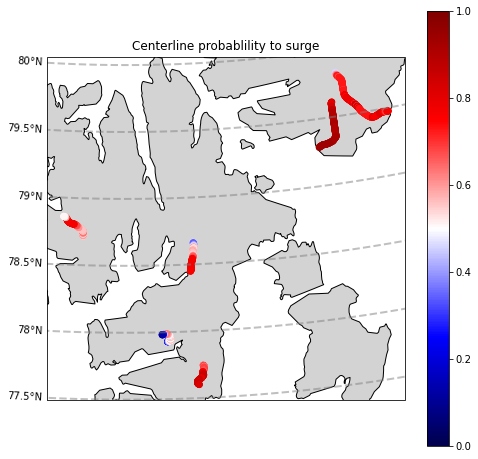

In [51]:
# avg_loc_center = svalbard_glaciers[svalbard_glaciers.GLACIER_NAME.isin(centerlines_glacs)].groupby('GLACIER_NAME').mean()
# svalbard_bounding_box = {'left_lon':9.9, 'right_lon':26.2, 'bottom_lat':76.276, 'top_lat':80.5}
fig, ax = plt.subplots(1, figsize=(8,8))

# proj = ccrs.PlateCarree()                       # the projection you want to use, many are supported, 
# proj = ccrs.Mercator() 
proj = ccrs.UTM(33, southern_hemisphere=False, globe=None)# the projection you want to use, many are supported, 
                                                # this one is the standard for geographic coordinates
    
ax = plt.axes(projection=proj)                  # sets the projection

ax.add_feature(cartopy.feature.OCEAN            # add ocean feature
               , zorder=0                       # layer where ocean should plot; 0 is base   
               , facecolor='w'                  # color of the ocean
              )           

ax.add_feature(cartopy.feature.LAND             # add continent feature
               , zorder=0                       # layer where continent should plot; 0 is base
               , edgecolor='black'              # coastline color
               , facecolor='lightgray'          # continent color
              ) 

# ax.add_geometries(outlines['geometry'], crs=proj) #plot the outlines of glaciers

# ax.coastlines(resolution='110m')                # the level of resolution to render the drawings, 
                                                # see documentation for more details
                
gl = ax.gridlines(crs=ccrs.PlateCarree()        
                , draw_labels=True              # label coordinates
                , linewidth=2                   # line properties can be changed similar to matplotlib
                , color='gray'
                , alpha=0.5
                , linestyle='--')

gl.xlabels_top = gl.ylabels_right = False                          # where labels shouldn't be
gl.xlines = True  
gl.ylines = True  # turn off x-axis
gl.ylabels_bottom = True
gl.xlocator = mticker.FixedLocator([-180, -90, 0, 90, 180])        # sets longitude tick marks
gl.xformatter = LONGITUDE_FORMATTER                                # set cartopy formatting
gl.yformatter = LATITUDE_FORMATTER

gl.xlabel_style = {'size': 15, 'color': 'gray'}                    # change features about the longitude labels
gl.xlabel_style = {'color': 'red', 'weight': 'bold'}

cbar = ax.scatter(aust_basin3_map.x.values
        ,aust_basin3_map.y.values               # plots your data points on the axes
        , marker='o'                                 # symbol for data point
        , c=aust_basin3_map.Probability_1
        , cmap = 'seismic'# symbol facecolor
#         , edgecolor='black'                          # symbol edgecolor
        , alpha=1, vmin=0, vmax=1
#         , s=250# opacity
#         , transform=ccrs.PlateCarree()
#         ,label='Not observed'
          )              # projection to plot data in

ax.scatter(brasvel_map.x.values
        ,brasvel_map.y.values               # plots your data points on the axes
        , marker='o'                                 # symbol for data point
        , c=brasvel_map.Probability_1
        , cmap = 'seismic'# symbol facecolor
#         , edgecolor='black'                          # symbol edgecolor
        , alpha=1, vmin=0, vmax=1
#         , s=250# opacity
#         , transform=ccrs.PlateCarree()
#         ,label='Not observed'
          )              # projection to plot data in

ax.scatter(morsne_map.x.values
        ,morsne_map.y.values               # plots your data points on the axes
        , marker='o'                                 # symbol for data point
        , c=morsne_map.Probability_1
        , cmap = 'seismic'# symbol facecolor
#         , edgecolor='black'                          # symbol edgecolor
        , alpha=1, vmin=0, vmax=1
#         , s=250# opacity
#         , transform=ccrs.PlateCarree()
#         ,label='Not observed'
          )              # projection to plot data in

ax.scatter(tuna_map.x.values
        ,tuna_map.y.values               # plots your data points on the axes
        , marker='o'                                 # symbol for data point
        , c=tuna_map.Probability_1
        , cmap = 'seismic'# symbol facecolor
#         , edgecolor='black'                          # symbol edgecolor
        , alpha=1, vmin=0, vmax=1
#         , s=250# opacity
#         , transform=ccrs.PlateCarree()
#         ,label='Not observed'
          )              # projection to plot data in

ax.scatter(kongs_map.x.values
        ,kongs_map.y.values               # plots your data points on the axes
        , marker='o'                                 # symbol for data point
        , c=kongs_map.Probability_1
        , cmap = 'seismic'# symbol facecolor
#         , edgecolor='black'                          # symbol edgecolor
        , alpha=1, vmin=0, vmax=1
#         , s=250# opacity
#         , transform=ccrs.PlateCarree()
#         ,label='Not observed'
          )              # projection to plot data in

ax.scatter(slakbreen_map.x.values
        ,slakbreen_map.y.values               # plots your data points on the axes
        , marker='o'                                 # symbol for data point
        , c=slakbreen_map.Probability_1
        , cmap = 'seismic'# symbol facecolor
#         , edgecolor='black'                          # symbol edgecolor
        , alpha=1, vmin=0, vmax=1
#         , s=250# opacity
#         , transform=ccrs.PlateCarree()
#         ,label='Not observed'
          )              # projection to plot data in



plt.colorbar(cbar)
plt.title('Centerline probablility to surge')

plt.text(aust_basin3_map.x[np.around((len(aust_basin3_map.x) - 1)/2, decimals=-1)] - 100000, aust_basin3_map.y[np.around((len(aust_basin3_map.y) - 1)/2, decimals=-1)] + 25000
         , 'Austfonna-Basin 3'
         , bbox=dict(boxstyle='square,pad=0.1'
         ,fc='white'
         , ec='none')) 

plt.text(brasvel_map.x[np.around((len(brasvel_map.x) - 1)/2, decimals=-1)] - 70000, brasvel_map.y[np.around((len(brasvel_map.y) - 1)/2, decimals=-1)] + 5000
         , 'Brasvellbreen'
         , bbox=dict(boxstyle='square,pad=0.1'
         ,fc='white'
         , ec='none')) 

plt.text(morsne_map.x[np.around((len(morsne_map.x) - 1)/2, decimals=-1)] + 10000, morsne_map.y[np.around((len(morsne_map.y) - 1)/2, decimals=-1)] + 5000
         , 'Morsnevbreen'
         , bbox=dict(boxstyle='square,pad=0.1'
         ,fc='white'
         , ec='none')) 

plt.text(tuna_map.x[np.around((len(tuna_map.x) - 1)/2, decimals=-1)] + 10000, tuna_map.y[np.around((len(tuna_map.y) - 1)/2, decimals=-1)] + 5000
         , 'Tunabreen'
         , bbox=dict(boxstyle='square,pad=0.1'
         ,fc='white'
         , ec='none')) 

plt.text(kongs_map.x[np.around((len(kongs_map.x) - 1)/2, decimals=-1)] + 10000, kongs_map.y[np.around((len(kongs_map.y) - 1)/2, decimals=-1)] + 1000
         , 'Kongsvegen'
         , bbox=dict(boxstyle='square,pad=0.1'
         ,fc='white'
         , ec='none')) 


### Brasvellbreen

In [ ]:
brasvel_map = df_probability_surge_full.loc[['RGI60-07.00025']]
brasvel_map

In [ ]:
# avg_loc_center = svalbard_glaciers[svalbard_glaciers.GLACIER_NAME.isin(centerlines_glacs)].groupby('GLACIER_NAME').mean()
# svalbard_bounding_box = {'left_lon':9.9, 'right_lon':26.2, 'bottom_lat':76.276, 'top_lat':80.5}
fig, ax = plt.subplots(1, figsize=(8,8))

# proj = ccrs.PlateCarree()                       # the projection you want to use, many are supported, 
# proj = ccrs.Mercator() 
proj = ccrs.UTM(33, southern_hemisphere=False, globe=None)# the projection you want to use, many are supported, 
                                                # this one is the standard for geographic coordinates
    
ax = plt.axes(projection=proj)                  # sets the projection

ax.add_feature(cartopy.feature.OCEAN            # add ocean feature
               , zorder=0                       # layer where ocean should plot; 0 is base   
               , facecolor='w'                  # color of the ocean
              )           

ax.add_feature(cartopy.feature.LAND             # add continent feature
               , zorder=0                       # layer where continent should plot; 0 is base
               , edgecolor='black'              # coastline color
               , facecolor='lightgray'          # continent color
              ) 

# ax.add_geometries(outlines['geometry'], crs=proj) #plot the outlines of glaciers

# ax.coastlines(resolution='110m')                # the level of resolution to render the drawings, 
                                                # see documentation for more details
                
gl = ax.gridlines(crs=ccrs.PlateCarree()        
                , draw_labels=True              # label coordinates
                , linewidth=2                   # line properties can be changed similar to matplotlib
                , color='gray'
                , alpha=0.5
                , linestyle='--')

gl.xlabels_top = gl.ylabels_right = False                          # where labels shouldn't be
gl.xlines = True  
gl.ylines = True  # turn off x-axis
gl.ylabels_bottom = True
gl.xlocator = mticker.FixedLocator([-180, -90, 0, 90, 180])        # sets longitude tick marks
gl.xformatter = LONGITUDE_FORMATTER                                # set cartopy formatting
gl.yformatter = LATITUDE_FORMATTER

gl.xlabel_style = {'size': 15, 'color': 'gray'}                    # change features about the longitude labels
gl.xlabel_style = {'color': 'red', 'weight': 'bold'}

cbar = ax.scatter(brasvel_map.x.values
        ,brasvel_map.y.values               # plots your data points on the axes
        , marker='o'                                 # symbol for data point
        , c=brasvel_map.Probability_1
        , cmap = 'seismic'# symbol facecolor
#         , edgecolor='black'                          # symbol edgecolor
        , alpha=1, vmin=0, vmax=1
#         , s=250# opacity
#         , transform=ccrs.PlateCarree()
#         ,label='Not observed'
          )              # projection to plot data in

fig.colorbar(cbar)
plt.title('Brasvelbreen centerline probablility to surge')
# ax.legend(['surge type', 'no surge', 'no surge data', 'center line data'], fontsize=15)
# ax.legend(fontsize=15)a

### Shape values along the centerline line

In [ ]:
aust_basin3 = test_full.loc[['RGI60-07.00027']]

In [ ]:
aust_basin3

In [ ]:
# Upper part
shap.force_plot(explainer.expected_value, shap_values[691], aust_basin3.iloc[0])    

In [ ]:
# Middle part
shap.force_plot(explainer.expected_value, shap_values[145+691], aust_basin3.iloc[145])    

In [ ]:
# Lower part
shap.force_plot(explainer.expected_value, shap_values[980], aust_basin3.iloc[289])   

### Brasvellbreen

In [ ]:
brasvell = test_full.loc[['RGI60-07.00025']]
brasvell

In [ ]:
223/2

In [ ]:
# Upper part
shap.force_plot(explainer.expected_value, shap_values[382], aust_basin3.iloc[0])    

In [ ]:
# Middle part
shap.force_plot(explainer.expected_value, shap_values[382+111], aust_basin3.iloc[111])    

In [ ]:
# Lower part
shap.force_plot(explainer.expected_value, shap_values[604], aust_basin3.iloc[-1])    

### Morsnevbreen

In [ ]:
mornsnev = test_full.loc[['RGI60-07.00296']]
mornsnev

In [ ]:
# Upper part
shap.force_plot(explainer.expected_value, shap_values[18179], aust_basin3.iloc[0]) 

In [ ]:
# Middle part
shap.force_plot(explainer.expected_value, shap_values[18179+54], aust_basin3.iloc[54]) 

In [ ]:
# Lower part
shap.force_plot(explainer.expected_value, shap_values[18286], aust_basin3.iloc[-1]) 

### Tunabreen

In [ ]:
tuna = test_full.loc[['RGI60-07.01458']]
tuna

In [ ]:
128/2

In [ ]:
# Upper part
shap.force_plot(explainer.expected_value, shap_values[83216], aust_basin3.iloc[0]) 

In [ ]:
# Middle part
shap.force_plot(explainer.expected_value, shap_values[83216+64], aust_basin3.iloc[64]) 

In [ ]:
# Lower part
shap.force_plot(explainer.expected_value, shap_values[83216+127], aust_basin3.iloc[-1]) 

### Kongsvegen

In [ ]:
kongs = test_full.loc[['RGI60-07.01481']]
kongs

In [ ]:
142/2

In [ ]:
# Upper part
shap.force_plot(explainer.expected_value, shap_values[85726], aust_basin3.iloc[0]) 

In [ ]:
# Middle part
shap.force_plot(explainer.expected_value, shap_values[85726+71], aust_basin3.iloc[71]) 

In [ ]:
# Lower part
shap.force_plot(explainer.expected_value, shap_values[85726+141], aust_basin3.iloc[-1]) 